In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import sys
sys.path.append('C:/Users/mosta/OneDrive - UNCG\Academics/CSC 699 - Thesis/repos/brain_connectome/graphIO')
from graphIO import read_ppmi_data
from asymmetry import calculate_inter_hemispheric_asymmetry_vector
from sklearn.cross_decomposition import CCA
import matplotlib.pyplot as plt

In [14]:
PPMI_DIR = "C:/Users/mosta/OneDrive - UNCG/Academics/CSC 699 - Thesis/data/ppmi"
DEVICE = device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ATLAS = 116
HIDDEN_DIM = 256
LATENT_DIM = 100
EPOCHS = 100
ASYMMETRY_METHOD = 'ai'
CCA_COMPONENTS = 2
LEARNING_RATE = 0.00001
BATCH_SIZE = 32

In [15]:
ppmi_data = read_ppmi_data(PPMI_DIR)

Processing directories: 100%|██████████| 209/209 [00:01<00:00, 126.29it/s]


In [16]:
control_matrices = np.array([ppmi_data['sub-control'][i] for i in ppmi_data['sub-control']])
patient_matrices = np.array([ppmi_data['sub-patient'][i] for i in ppmi_data['sub-patient']])
prodromal_matrices = np.array([ppmi_data['sub-prodromal'][i] for i in ppmi_data['sub-prodromal']])
swedd_matrices = np.array([ppmi_data['sub-swedd'][i] for i in ppmi_data['sub-swedd']])
print(control_matrices.shape, patient_matrices.shape, prodromal_matrices.shape, swedd_matrices.shape)

(15, 116, 116) (113, 116, 116) (67, 116, 116) (14, 116, 116)


In [17]:
control_asymm_vectors = np.array([calculate_inter_hemispheric_asymmetry_vector(matrix, method=ASYMMETRY_METHOD) for matrix in control_matrices])
patient_asymm_vectors = np.array([calculate_inter_hemispheric_asymmetry_vector(matrix, method=ASYMMETRY_METHOD) for matrix in patient_matrices])
prodromal_asymm_vectors = np.array([calculate_inter_hemispheric_asymmetry_vector(matrix, method=ASYMMETRY_METHOD) for matrix in prodromal_matrices])
swedd_asymm_vectors = np.array([calculate_inter_hemispheric_asymmetry_vector(matrix, method=ASYMMETRY_METHOD) for matrix in swedd_matrices])
print(control_asymm_vectors.shape, patient_asymm_vectors.shape, prodromal_asymm_vectors.shape, swedd_asymm_vectors.shape)

(15, 58) (113, 58) (67, 58) (14, 58)


In [18]:
tensors = {}
tensors['control'] = torch.tensor(control_asymm_vectors.reshape((-1, 1, ATLAS//2)), dtype=torch.float32).unsqueeze(1)
tensors['patient'] = torch.tensor(patient_asymm_vectors.reshape((-1, 1, ATLAS//2)), dtype=torch.float32).unsqueeze(1)
tensors['prodromal'] = torch.tensor(prodromal_asymm_vectors.reshape((-1, 1, ATLAS//2)), dtype=torch.float32).unsqueeze(1)
tensors['swedd'] = torch.tensor(swedd_asymm_vectors.reshape((-1, 1, ATLAS//2)), dtype=torch.float32).unsqueeze(1)

In [19]:
class AsymmetryVAE(nn.Module):
    def __init__(self, input_shape=(1, 1, ATLAS//2), hidden_dim=HIDDEN_DIM, latent_dim=LATENT_DIM):
        super(AsymmetryVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),  # Assuming a small convolution kernel
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )
        
        # Calculate the flattened size after convolution
        self.flattened_size = 64 * 1 * ATLAS//2
        
        self.fc1 = nn.Linear(self.flattened_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, latent_dim)
        self.fc3 = nn.Linear(hidden_dim, latent_dim)
        
        self.fc4 = nn.Linear(latent_dim, hidden_dim)
        self.fc5 = nn.Linear(hidden_dim, self.flattened_size)
        
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (64, 1, ATLAS//2)),
            nn.ConvTranspose2d(64, 32, 3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, padding=1),
            nn.Sigmoid()
        )
        
    def encode(self, x):
        h = self.encoder(x)
        h = torch.relu(self.fc1(h))
        return self.fc2(h), self.fc3(h)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        h = torch.relu(self.fc4(z))
        h = torch.relu(self.fc5(h))
        h = self.decoder(h)
        return h
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

def loss_function(recon_x, x, mu, logvar):
    MSE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD

def calculate_mse(dataloader, model):
    model.eval()
    mse_loss = 0
    with torch.no_grad():
        for data, _ in dataloader:
            data = data.to(device)
            recon, _, _ = model(data)
            mse_loss += nn.functional.mse_loss(recon, data, reduction='sum').item()
    return mse_loss / len(dataloader.dataset)

# Function to get the latent space representation
def get_latent_space(model, data_vector, use_mean=True):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # No need to compute gradients
        # Ensure the data is in the correct shape and tensor format
        data_tensor = torch.tensor(data_vector.reshape(1, 1, 1, ATLAS//2), dtype=torch.float32).to(device)
        # Pass through the encoder to get mu and logvar
        mu, logvar = model.encode(data_tensor)
        if use_mean:
            return mu.cpu().numpy()  # Return the mean as the latent representation
        else:
            # Sample from the distribution using reparameterization trick
            z = model.reparameterize(mu, logvar)
            return z.cpu().numpy()  # Return the sampled latent representation

In [20]:
models = {}
optimizers = {}
for group in ['control', 'patient', 'prodromal', 'swedd']:
    models[group] = AsymmetryVAE().to(DEVICE)
    optimizers[group] = optim.Adam(models[group].parameters(), lr=1e-4)
    dataset = TensorDataset(tensors[group], tensors[group])
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
    print(f'Training model for group: {group}')
    for epoch in range(1, EPOCHS + 1):
        models[group].train()
        train_loss = 0
        for batch_idx, (data, _) in enumerate(dataloader):
            data = data.to(device)
            optimizers[group].zero_grad()
            recon_batch, mu, logvar = models[group](data)
            loss = loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(models[group].parameters(), max_norm=1.0)
            train_loss += loss.item()
            optimizers[group].step()
            if batch_idx % 10 == 0:
                print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(dataloader.dataset)} ({100. * batch_idx / len(dataloader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')
        avg_train_loss = train_loss / len(dataloader.dataset)
        print(f'====> Epoch: {epoch} Average loss: {avg_train_loss:.4f}')
        
        # Calculate validation MSE
        val_mse = calculate_mse(dataloader, models[group])
        print(f'====> Validation MSE after Epoch {epoch}: {val_mse:.4f}')

Training model for group: control
Train Epoch: 1 [0/15 (0%)]	Loss: 13.440023
====> Epoch: 1 Average loss: 13.4400
====> Validation MSE after Epoch 1: 13.1160
Train Epoch: 2 [0/15 (0%)]	Loss: 13.205457
====> Epoch: 2 Average loss: 13.2055
====> Validation MSE after Epoch 2: 12.7988
Train Epoch: 3 [0/15 (0%)]	Loss: 12.924191
====> Epoch: 3 Average loss: 12.9242
====> Validation MSE after Epoch 3: 12.6207
Train Epoch: 4 [0/15 (0%)]	Loss: 12.598563
====> Epoch: 4 Average loss: 12.5986
====> Validation MSE after Epoch 4: 12.3870
Train Epoch: 5 [0/15 (0%)]	Loss: 12.541660
====> Epoch: 5 Average loss: 12.5417
====> Validation MSE after Epoch 5: 12.2465
Train Epoch: 6 [0/15 (0%)]	Loss: 12.286804
====> Epoch: 6 Average loss: 12.2868
====> Validation MSE after Epoch 6: 11.9378
Train Epoch: 7 [0/15 (0%)]	Loss: 12.068985
====> Epoch: 7 Average loss: 12.0690
====> Validation MSE after Epoch 7: 11.8479
Train Epoch: 8 [0/15 (0%)]	Loss: 11.839353
====> Epoch: 8 Average loss: 11.8394
====> Validation M

In [27]:
least_sample_num = np.min([control_asymm_vectors.shape[0], patient_asymm_vectors.shape[0], prodromal_asymm_vectors.shape[0], swedd_asymm_vectors.shape[0]])
data_control = control_asymm_vectors[:least_sample_num]
data_patient = patient_asymm_vectors[:least_sample_num]
data_prodromal = prodromal_asymm_vectors[:least_sample_num]
data_swedd = swedd_asymm_vectors[:least_sample_num]

In [28]:
latent_space_control = np.array([get_latent_space(models['control'], vec) for vec in data_control]).reshape((-1, LATENT_DIM))
latent_space_patient = np.array([get_latent_space(models['patient'], vec) for vec in data_patient]).reshape((-1,LATENT_DIM))
latent_space_prodromal = np.array([get_latent_space(models['prodromal'], vec) for vec in data_prodromal]).reshape((-1,LATENT_DIM))
latent_space_swedd = np.array([get_latent_space(models['swedd'], vec) for vec in data_swedd]).reshape((-1,LATENT_DIM))

In [29]:
input_data_1 = data_control
input_data_2 = data_patient
latent_space_1 = latent_space_control
latent_space_2 = latent_space_patient

In [30]:
# Assuming data_class_1 and data_class_2 are your input datasets
cca = CCA(n_components=CCA_COMPONENTS)
cca_input_1, cca_input_2 = cca.fit_transform(input_data_1, input_data_2)

correlations_input = [np.corrcoef(cca_input_1[:, i], cca_input_2[:, i])[0, 1] for i in range(cca_input_1.shape[1])]
print("Canonical Correlations on Input:", correlations_input)

Canonical Correlations on Input: [1.0, 1.0]


In [31]:
# Assuming latent_space_class_1 and latent_space_class_2 are obtained from VAEs
cca = CCA(n_components=CCA_COMPONENTS)
cca_latent_1, cca_latent_2 = cca.fit_transform(latent_space_1, latent_space_2)

correlations_latent = [np.corrcoef(cca_latent_1[:, i], cca_latent_2[:, i])[0, 1] for i in range(cca_latent_1.shape[1])]
print("Canonical Correlations on Latent Space:", correlations_latent)

Canonical Correlations on Latent Space: [1.0, 0.9999999999999998]


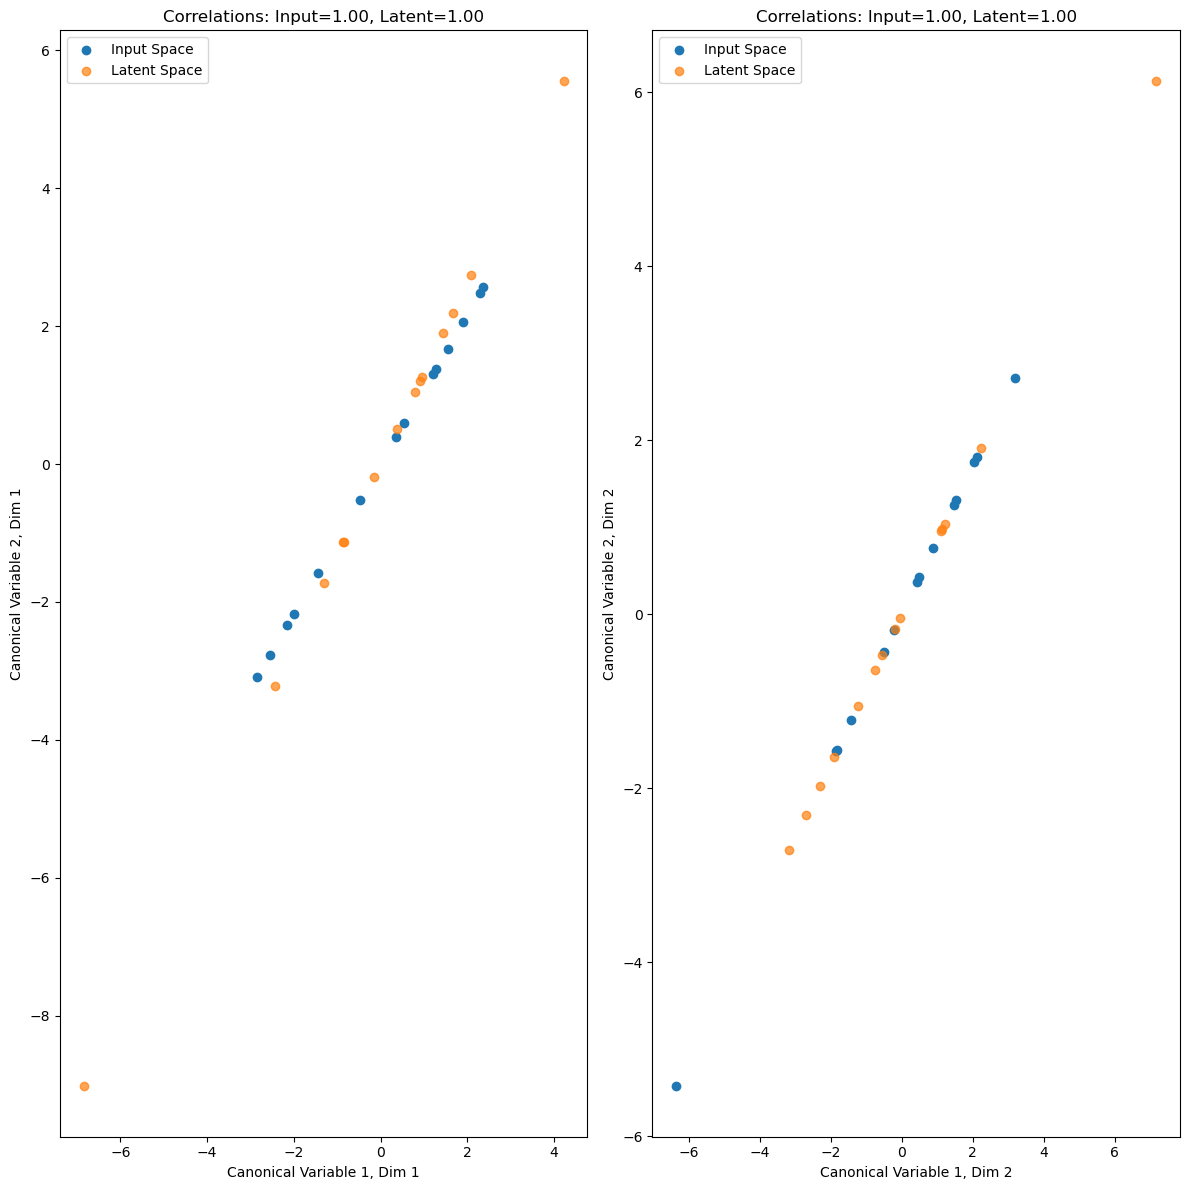

In [33]:
plt.figure(figsize=(12, 12))
for i in range(CCA_COMPONENTS):  # Assuming n_components=2
    plt.subplot(CCA_COMPONENTS//2, CCA_COMPONENTS, i + 1)
    plt.scatter(cca_input_1[:, i], cca_input_2[:, i], label='Input Space')
    plt.scatter(cca_latent_1[:, i], cca_latent_2[:, i], label='Latent Space', alpha=0.7)
    plt.xlabel(f'Canonical Variable 1, Dim {i+1}')
    plt.ylabel(f'Canonical Variable 2, Dim {i+1}')
    plt.title(f'Correlations: Input={correlations_input[i]:.2f}, Latent={correlations_latent[i]:.2f}')
    plt.legend()
plt.tight_layout()
plt.show()